In [4]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [5]:
# This file is a simple implementation of the 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ml_trading_module import create_train_test_file, create_dataset, get_accuracy, signal
import datetime

model = Sequential()
# data_file = pd.read_csv(r"/storage/eurusd_train_normed.csv")
data_file = pd.read_csv(r"/storage/ccyData.csv")
#eurusd_test = pd.read_csv(r"/storage/eurusd_test_normed.csv")
data_file = data_file.replace(np.nan, 0)
#eurusd_test = eurusd_test.replace(np.nan, 0)
performance_store = {"data_size" : [], "Accuracy_Score" :[], "epochs": [] , "Info_Ratio" : [], "run_time" : []}
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
look_back = 66 # [21, 66]
trade_horizon = 24
model_features = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff",
                   "MF_ema_diff","LF_ema_diff", "LDN", "NY", "Asia", "target"]
data_size = 2500
test_split = 0.75
# roughly 3 yrs of data slightly less actually
window = 15000
# the length of our prediction

# standardise the data
data_normed = standardise_data(data_file, model_features, window)
data_normed['Date'] = data_file['Date']
data_normed['CCY'] = data_file['CCY']
data_normed['logret'] = data_file['logret']
data_normed['LDN'] = data_file['LDN']
data_normed['NY'] = data_file['NY']
data_normed['Asia'] = data_file['Asia']
data_normed['target_raw'] = data_file['target']
data_normed['target'] = data_file['target_binary']

# create data_set
train , test = create_train_test_file(data_file, data_size, test_split)
train_sample = train[model_features].values
test_sample = test[model_features].values
 # Parse the values into the LSTM format
train_data , train_target, null_dates = create_dataset(train_sample,False, look_back, test)
test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)

# reshape seems to add another list around every observation
train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
train_target = train_target.reshape(train_target.shape[0], 1)
test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
test_target = test_target.reshape(test_target.shape[0], 1)

# Build up the model
BATCH_SIZE = 300
no_features = train_data.shape[2]
model = Sequential()
model.add(LSTM(4,batch_input_shape = (None,look_back,no_features), return_sequences = True))
model.add(LSTM(1, return_sequences = False, activation="tanh"))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])

EPOCH = 1000
# train the model
# verbose = 1 gives the output of the training.
start_time = datetime.datetime.now()
lstm_engine = model.fit(train_data,train_target,epochs = EPOCH,validation_data=(test_data,test_target), verbose=1)
run_time = datetime.datetime.now() - start_time
# run training on the test data
results = model.predict(test_data)
# The % threshold needed to trigger a signal either way
thold = 0.55
predicted = [signal(i, thold) for i in results]
acc_score = get_accuracy(predicted, test_target)
predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
test_results = pd.merge(test,predictions,how="left", on="Date").fillna(0)
# calculate the returns of the signal
test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
# no shift needed as we have already done that in previous step
test_results['strat_returns'] = test_results['logret']*test_results['scaled_signal']
test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
strat_return = test_results['strat_returns'].sum()
information_ratio = (test_results['strat_returns'].mean()*260)/(test_results['strat_returns'].std()*np.sqrt(260))

# Store the data as needed
performance_store['data_size'].append(data_size)
performance_store['epochs'].append(EPOCH)
performance_store['Accuracy_Score'].append(acc_score)
performance_store['Info_Ratio'].append(information_ratio)
performance_store['run_time'].append(run_time)
performance_df = pd.DataFrame(performance_store)
save_results = r"/storage/test_result_size%s_lkbk%s_Epochs%s_thold%s.csv" % (data_size, look_back, EPOCH, thold)
test_results.to_csv( save_results,index = False)

TypeError: standardise_data() missing 1 required positional argument: 'window'

In [4]:
# This file is a simple implementation of the 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ml_trading_module import create_train_test_file, create_dataset, get_accuracy, signal
import datetime

file_location = r"/storage/ccyData.csv"

performance_store = {"data_size" : [], "Accuracy_Score" : [], "epochs": [],
                     "Info_Ratio" : [], "run_time" : [], "train_date_st": [], "test_date_st": []}
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
look_back = 60 # [21, 66]
trade_horizon = 24
test_buffer = 5
data_size = 5000
test_split = 0.5
total_data_needed = int(data_size*(1 + test_split)) + test_buffer
###### Set Targets ##############
trade_horizon = 24 # in hours
use_risk_adjusted = False # if True: training on the sharpe return else raw
concat_results = True 
use_classifier = True
################### Standardise Entire Dataset using rolling lookback windows #######
# roughly ~3 yrs of data 
window = 17500
use_pca = 3 # if = 0 then implies do not use pca in the model
################### Standardise Entire Dataset using rolling lookback windows ###############
start_row = 0
################ Loop through the full dataset in terms of the training and testing.
start_row = 85000
use_separated_chunk = False # Use a rolling window to train and test
data_normed, model_features, features_to_standardise = initialise_process(file_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca)
################ Loop through the full dataset in terms of the training and testing.
while start_row < data_normed.shape[0]:
    # first check if there is enough data left
    if (start_row + total_data_needed) > data_normed.shape[0]:
        # if we are about to go over the limit, then just return the last data_size + test size proportion of data
        trunc_data = data_normed.iloc[-total_data_needed:,:]
    # we need to increment over the data size
    if use_separated_chunk:
        # this means we jump across the full previous train and test data
        trunc_data = data_normed.loc[start_row:,:]
        start_row += total_data_needed
    if concat_results:
        # in this instance, we can to add to the start row first before chunking the data
        start_row += test_split
        # we are training on all data available up until that point, and testing x timeperiods ahead
        trunc_data = data_normed.loc[:start_row,:]  
    else:
        # this rolls the data so that the new training will overlap on the old test set and create a new separated test set
        trunc_data = data_normed.loc[start_row:,:]
        start_row += data_size
    # standardise the data
    #################### Set up training and testing ########################
    
    # create data_set
    train , test = create_train_test_file(trunc_data, data_size, test_split, test_buffer)
    if test.shape[0] <= (look_back+test_buffer+trade_horizon):
        break
    if use_pca > 0:
        train, test, var_explained = get_pca_features(train,test, features_to_standardise, use_pca)
    train_sample = train[model_features].values
    test_sample = test[model_features].values

     # Parse the values into the LSTM format
    train_data , train_target, null_dates = create_dataset(train_sample,False, look_back, test)
    test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)
    
    # reshape seems to add another list around every observation
    train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
    train_target = train_target.reshape(train_target.shape[0], 1)
    test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
    test_target = test_target.reshape(test_target.shape[0], 1)
    #### Set up model parameters
    # Build up the model
    BATCH_SIZE = 300
    no_features = train_data.shape[2]
    model = Sequential()
    model.add(LSTM(4,batch_input_shape = (None,look_back,no_features), return_sequences = True))
    model.add(LSTM(1, return_sequences = False, activation="softmax"))
    model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
    
    EPOCH = 350
    # train the model
    # verbose = 1 gives the output of the training.
    start_time = datetime.datetime.now()
    lstm_engine = model.fit(train_data,train_target,epochs = EPOCH,validation_data=(test_data,test_target), verbose= 1)
    run_time = datetime.datetime.now() - start_time
    # run training on the test data
    results = model.predict(test_data)
    # The % threshold needed to trigger a signal either way
    thold = 0.55
    predicted = [signal(i, thold) for i in results]
    acc_score = get_accuracy(predicted, test_target)
    # This needs to change to handle the change in the target
    predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
    test_results = pd.merge(test,predictions,how="left", on="Date").fillna(0)
    # calculate the returns of the signal
    test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
    # no shift needed as we have already done that in previous step
    test_results['strat_returns'] = test_results['logret']*test_results['scaled_signal']
    test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
    strat_return = test_results['strat_returns'].sum()
    information_ratio = (test_results['strat_returns'].mean()*260)/(test_results['strat_returns'].std()*np.sqrt(260))
    
    # Store the data as needed
    performance_store['data_size'].append(data_size)
    performance_store['epochs'].append(EPOCH)
    performance_store['Accuracy_Score'].append(acc_score)
    performance_store['Info_Ratio'].append(information_ratio)
    performance_store['run_time'].append(run_time)
    performance_store['train_date_st'].append(trunc_data['Date'].iloc[0])
    performance_store['test_date_st'].append(test_results['Date'].iloc[0])
    performance_df = pd.DataFrame(performance_store)
    save_results = r"/storage/test_result_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold)
    test_results.to_csv(save_results,index = False)
    performance_df.to_csv(r"/storage/performance_df_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold)) 

TypeError: initialise_process() missing 1 required positional argument: 'use_random_train_data'

In [ ]:
# paperspace code for looping through the data series

model = Sequential()
###################### Import Data ##################################
# data_file = pd.read_csv(r"/storage/eurusd_train_normed.csv")
data_file = pd.read_csv(r"/storage/ccyData.csv")
data_file = data_file.replace(np.nan, 0)
performance_store = {"data_size" : [], "Accuracy_Score" : [], "epochs": [],
                     "Info_Ratio" : [], "run_time" : [], "train_date_st": [], "test_date_st": []}
###################### Add Parameters ##################################################
# this looks back over a set period as the memory for the LSTM
look_back = 66 # [21, 66]
trade_horizon = 24
model_features = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff",
                   "MF_ema_diff","LF_ema_diff", "LDN", "NY", "Asia", "target"]
test_buffer = 5
data_size = 2500
test_split = 0.75
total_data_needed = int(data_size*(1 + test_split)) + test_buffer

while start_row < data_file.shape[0]:
    # first check if there is enough data left
    if (start_row + total_data_needed) > data_file.shape[0]:
        # if we are about to go over the limit, then just return the last data_size + test size proportion of data
        trunc_data = data_file.iloc[-total_data_needed:,:]
    # we need to increment over the data size
    if use_separated_chunk:
        # this means we jump across the full previous train and test data
        start_row += total_data_needed
        trunc_data = data_file.loc[start_row:,:]
    if use_rolling_chunk:
        # this rools the data so that the new training will overlap on the old test set and create a new separated test set
        start_row += data_size
        trunc_data = data_file.loc[start_row:,:]



In [1]:
##### FOR PCA features  && train on random data!####
# This file is a simple implementation of the 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from ml_trading_module import *
from model_functions import *
import datetime
import sys

file_location = r"/storage/ccyData.csv"
performance_store = {"data_size" : [], "Accuracy_Score" : [], "epochs": [],
                     "Info_Ratio" : [], "run_time" : [], "train_date_st": [], "test_date_st": []}
params_dict = set_params_random_forests()
lstm_dict = set_params_LSTM()
use_random_train_data = params_dict['use_random_train_data']
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
EPOCH = lstm_dict['EPOCH']
first_layer = lstm_dict['first_layer']
second_layer = lstm_dict['second_layer']
look_back = lstm_dict['look_back'] 

# [i for i in range(25,301,25)] # [21, 66]
# if running pca, max features can only be same or less than the full total of features
test_buffer = params_dict['test_buffer']
data_size = params_dict['data_size'] #  initially using 1500 training points
# I.e. append the data into one df over each training window, but also use all available up until that point
concat_results = params_dict['concat_results']
# if the number is > 1, then the code takes that as the number of test points you want to use
test_split = params_dict['test_split'] # roughly one month test ahead, which is a one month retrain period
# signal threshold, when using classifier
thold = params_dict['thold']
total_data_needed = get_total_data_needed(test_split,data_size,test_buffer)
# standardisation window
window = params_dict['window']
###### Set Targets ##############
trade_horizon = params_dict['trade_horizon'] # in hours
use_risk_adjusted = params_dict['use_risk_adjusted'] # if True: training on the sharpe return else raw
use_binary = params_dict['use_binary'] # set to true if you are using the risk adjusted and want it binary for classification score
use_classifier = params_dict['use_classifier']
use_pca = params_dict['use_pca'] # if = 0 then implies do not use pca in the model
use_separated_chunk = params_dict['use_separated_chunk']
################### Standardise Entire Dataset using rolling lookback windows ###############
data_normed, model_features, features_to_standardise = initialise_process(file_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca,use_random_train_data, use_binary)
#data_normed = data_normed.replace(np.nan, 0)
start_row = data_size
 # Use a rolling window to train and test
################ Loop through the full dataset in terms of the training and testing.
if use_random_train_data:
    print("random starting, EPOCH %s" % str(EPOCH) )
    random_data_location = r"/storage/CcyRandomTrendLSTM.csv"
    train, model_features, features_to_standardise = initialise_process(random_data_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca, use_binary,use_random_train_data)
    test, model_features, features_to_standardise  = initialise_process(file_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca, 
                                                 use_binary ,use_random_train_data = False)
    if test.shape[0] <= (look_back+test_buffer+trade_horizon):
        sys.exit()
    if use_pca > 0:
        train, test, var_explained = get_pca_features(train,test, features_to_standardise, use_pca)
    train_sample = train[model_features].values
    test_sample = test[model_features].head(test.shape[0]-39).values # had to do this to make it work

     # Parse the values into the LSTM format
    train_data , train_target, null_dates = create_dataset(train_sample,False, look_back, test)
    test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)
    
    # reshape seems to add another list around every observation
    train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
    train_target = train_target.reshape(train_target.shape[0], 1)
    test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
    test_target = test_target.reshape(test_target.shape[0], 1)
    #### Set up model parameters
    # Build up the model
    BATCH_SIZE = None # previous was 32 batch and 33 lookback
    no_features = train_data.shape[2]
    model = Sequential()
    #model.add(LSTM(first_layer,batch_input_shape = (BATCH_SIZE,look_back,no_features), return_sequences = True))
    #model.add(LSTM(second_layer, return_sequences = False, activation="softmax"))
    #model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
    # newer method of learning
    model.add(LSTM(first_layer, batch_input_shape = (BATCH_SIZE,look_back,no_features), return_sequences = True))
    model.add(LSTM(second_layer, return_sequences = False, activation="softmax"))
    model.add(Dense(8, activation = "tanh"))
    model.add(Dense(1, activation = "linear"))
    model.compile(loss = "mse", optimizer="adam", metrics = ['accuracy'])
    # train the model
    # verbose = 1 gives the output of the training.
    start_time = datetime.datetime.now()
    lstm_engine = model.fit(train_data,train_target,epochs = EPOCH,validation_data=(test_data,test_target), verbose= 1)
    #lstm_engine = model.fit(train_data,train_target,epochs = EPOCH, validation_data=(test_data,test_target),batch_size = BATCH_SIZE, verbose = 1)
    import matplotlib.pyplot as plt
    fig , ax = plt.subplots(1,1,figsize=(10,8))
    plt.plot(lstm_engine.history['loss'])
    plt.show()
    run_time = datetime.datetime.now() - start_time
    # run training on the test data
    results = model.predict(test_data, batch_size = BATCH_SIZE, verbose = 1)
    # The % threshold needed to trigger a signal either way
    predicted = [i[0] for i in results] # [np.sign(i) for i in results] #[signal(i, thold) for i in results]
    acc_score = get_accuracy([np.sign(i) for i in results], test_target)
    # This needs to change to handle the change in the target
    predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
    test_results = pd.merge(test,predictions,how="left", on="Date").fillna(0)
    # calculate the returns of the signal
    test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
    # no shift needed as we have already done that in previous step
    test_results['strat_returns'] = test_results['logret']*test_results['scaled_signal']
    test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
    strat_return = test_results['strat_returns'].sum()
    information_ratio = (test_results['strat_returns'].mean()*260)/(test_results['strat_returns'].std()*np.sqrt(260))
    
    # Store the data as needed
    performance_store['data_size'].append(data_size)
    performance_store['epochs'].append(EPOCH)
    performance_store['Accuracy_Score'].append(acc_score)
    performance_store['Info_Ratio'].append(information_ratio)
    performance_store['run_time'].append(run_time)
    performance_store['train_date_st'].append(test_results['Date'].iloc[0])
    performance_store['test_date_st'].append(test_results['Date'].iloc[-1])
    performance_df = pd.DataFrame(performance_store)
    save_results = r"/storage/test_result_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold)
    test_results.to_csv(save_results,index = False)
    performance_df.to_csv(r"/storage/performance_df_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold))
else:
    # if not using random data then move to the normal method.
    ################ Loop through the full dataset in terms of the training and testing.
    while start_row < data_normed.shape[0]:
        # first check if there is enough data left
        if (start_row + total_data_needed) > data_normed.shape[0]:
            # if we are about to go over the limit, then just return the last data_size + test size proportion of data
            trunc_data = data_normed.iloc[-total_data_needed:,:]
        # we need to increment over the data size
        if use_separated_chunk:
            # this means we jump across the full previous train and test data
            trunc_data = data_normed.loc[start_row:,:]
            start_row += total_data_needed
        if concat_results:
            # in this instance, we can to add to the start row first before chunking the data
            start_row += test_split
            # we are training on all data available up until that point, and testing x timeperiods ahead
            trunc_data = data_normed.loc[:start_row,:]  
        else:
            # this rolls the data so that the new training will overlap on the old test set and create a new separated test set
            trunc_data = data_normed.loc[start_row:,:]
            start_row += data_size
        # standardise the data
        #################### Set up training and testing ########################
        
        # create data_set
        train , test = create_train_test_file(trunc_data, data_size, test_split, test_buffer)
        if test.shape[0] <= (look_back+test_buffer+trade_horizon):
            break
        if use_pca > 0:
            train, test, var_explained = get_pca_features(train,test, features_to_standardise, use_pca)
        train_sample = train[model_features].values
        test_sample = test[model_features].values
    
         # Parse the values into the LSTM format
        train_data , train_target, null_dates = create_dataset(train_sample,False, look_back, test)
        test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)
        
        # reshape seems to add another list around every observation
        train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
        train_target = train_target.reshape(train_target.shape[0], 1)
        test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
        test_target = test_target.reshape(test_target.shape[0], 1)
        #### Set up model parameters
        # Build up the model
        BATCH_SIZE = 6
        no_features = train_data.shape[2]
        model = Sequential()
        model.add(LSTM(120,batch_input_shape = (None,look_back,no_features), return_sequences = True))
        model.add(LSTM(1, return_sequences = False, activation="softmax"))
        model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
        
        EPOCH = 350
        # train the model
        # verbose = 1 gives the output of the training.
        start_time = datetime.datetime.now()
        lstm_engine = model.fit(train_data,train_target,epochs = EPOCH,validation_data=(test_data,test_target), verbose= 1)
        run_time = datetime.datetime.now() - start_time
        # run training on the test data
        results = model.predict(test_data)
        # The % threshold needed to trigger a signal either way
        #thold = 0.55
        predicted = [np.sign(i) for i in results] # [signal(i, thold) for i in results]
        acc_score = get_accuracy(predicted, test_target)
        # This needs to change to handle the change in the target
        predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
        test_results = pd.merge(test,predictions,how="left", on="Date").fillna(0)
        # calculate the returns of the signal
        test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
        # no shift needed as we have already done that in previous step
        test_results['strat_returns'] = test_results['logret']*test_results['scaled_signal']
        test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
        strat_return = test_results['strat_returns'].sum()
        information_ratio = (test_results['strat_returns'].mean()*260)/(test_results['strat_returns'].std()*np.sqrt(260))
        
        # Store the data as needed
        performance_store['data_size'].append(data_size)
        performance_store['epochs'].append(EPOCH)
        performance_store['Accuracy_Score'].append(acc_score)
        performance_store['Info_Ratio'].append(information_ratio)
        performance_store['run_time'].append(run_time)
        performance_store['train_date_st'].append(test_results['Date'].iloc[0])
        performance_store['test_date_st'].append(test_results['Date'].iloc[-1])
        performance_df = pd.DataFrame(performance_store)
        save_results = r"/storage/test_result_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold)
        test_results.to_csv(save_results,index = False)
        performance_df.to_csv(r"/storage/performance_df_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold))

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

random starting, EPOCH 1


W0915 14:40:29.788167 140096357189440 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 14:40:29.832605 140096357189440 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 14:40:29.848758 140096357189440 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 14:40:30.513771 140096357189440 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0915 14:40:30.925530 140096357189440 deprecation.py:323

Train on 3911 samples, validate on 111552 samples
Epoch 1/1
3911/3911 [==============================] - 82s 21ms/step - loss: 0.0018 - acc: 0.0064 - val_loss: 1.2364e-04 - val_acc: 5.3787e-05


<Figure size 1000x800 with 1 Axes>

111552/111552 [==============================] - 67s 601us/step


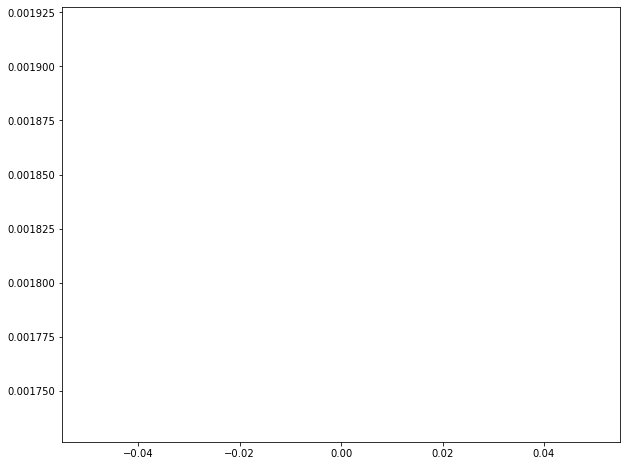

In [2]:
# quick testing of what is happening with this LSTM
import matplotlib.pyplot as plt
#fig , ax = plt.subplots(1,1,figsize=(12,8))
# lets see the history of the error update.
# want a smooth learning line
#ax.plot(lstm_engine.history['loss'])
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,1,figsize=(10,8))
plt.plot(lstm_engine.history['loss'])
plt.show()

In [3]:
def factors(n):
    factors = []
    for i in range (1,n+1):
        if (n % i) == 0:
            factors.append(i)
    return factors
x = 90
print(factors(((test.shape[0]) - x)))
#print((test.shape[0]) - x)
print(factors(4000-x))
print(set(factors(4000-x)).intersection(set(factors((test.shape[0]) - x))))
print(int(test.shape[0]-x-39))
print((4000-x)/90)


[1, 2, 5, 10, 11159, 22318, 55795, 111590]
[1, 2, 5, 10, 17, 23, 34, 46, 85, 115, 170, 230, 391, 782, 1955, 3910]
{1, 2, 10, 5}
111551
43.44444444444444


In [7]:
z = 3909
k = 111550
print(factors(z))
print(factors(k))

[1, 3, 1303, 3909]
[1, 2, 5, 10, 23, 25, 46, 50, 97, 115, 194, 230, 485, 575, 970, 1150, 2231, 2425, 4462, 4850, 11155, 22310, 55775, 111550]
